In [191]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

[Concat lags](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

[Kaggle](https://www.kaggle.com/learn/time-series)

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c store-sales-time-series-forecasting
!unzip /content/store-sales-time-series-forecasting.zip

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 500MB/s]
Archive:  /content/store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [2]:
pd.set_option('display.max_columns', None)

In [88]:
df = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col = 'date')

df = df.groupby(df.index).agg(
    {
        'sales': 'sum',
        'store_nbr': 'sum',
        'onpromotion': 'sum'
    }
)

df.head()

,sales,store_nbr,onpromotion
date,,,
2013-01-01,2511.618999,49005,0
2013-01-02,496092.417944,49005,0
2013-01-03,361461.231124,49005,0
2013-01-04,354459.677093,49005,0
2013-01-05,477350.121229,49005,0


In [89]:
len(df)

1684

In [90]:
df_oil = pd.read_csv('/content/oil.csv', parse_dates = ['date'], index_col = 'date')
df_oil.drop_duplicates(inplace=True)

df_oil.columns = ['oil_price']
df = df.merge(df_oil, left_index=True, right_index=True, how='left')
df.head()

,sales,store_nbr,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,49005,0,NaN
2013-01-02,496092.417944,49005,0,93.14
2013-01-03,361461.231124,49005,0,92.97
2013-01-04,354459.677093,49005,0,93.12
2013-01-05,477350.121229,49005,0,NaN


In [91]:
df = df.bfill()
df.isna().sum()

,0
sales,0
store_nbr,0
onpromotion,0
oil_price,0


In [92]:
df.head()

,sales,store_nbr,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,49005,0,93.14
2013-01-02,496092.417944,49005,0,93.14
2013-01-03,361461.231124,49005,0,92.97
2013-01-04,354459.677093,49005,0,93.12
2013-01-05,477350.121229,49005,0,93.20


In [93]:
holiday = pd.read_csv('/content/holidays_events.csv', parse_dates = ['date'], index_col = 'date')
holiday.drop_duplicates(inplace=True)

df = df.merge(holiday['type'], left_index=True, right_index=True, how='left')
df.rename(columns = {'type': 'holiday'}, inplace=True)
df.head()

,sales,store_nbr,onpromotion,oil_price,holiday
date,,,,,
2013-01-01,2511.618999,49005,0,93.14,Holiday
2013-01-02,496092.417944,49005,0,93.14,NaN
2013-01-03,361461.231124,49005,0,92.97,NaN
2013-01-04,354459.677093,49005,0,93.12,NaN
2013-01-05,477350.121229,49005,0,93.20,Work Day


In [94]:
df['holiday'] = pd.isna(df['holiday']).map({True: 0, False: 1})
df.head()

,sales,store_nbr,onpromotion,oil_price,holiday
date,,,,,
2013-01-01,2511.618999,49005,0,93.14,1
2013-01-02,496092.417944,49005,0,93.14,0
2013-01-03,361461.231124,49005,0,92.97,0
2013-01-04,354459.677093,49005,0,93.12,0
2013-01-05,477350.121229,49005,0,93.20,1


## Forecast

**Forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

**Forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target

**Lead time** is the time between the origin and the horizon, it's necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing

<br>

### strategies for producing the multiple target steps

#### **Multioutput model**
Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs

<br>

#### **Direct strategy**
Train a separate model for each step in the horizon

<br>

#### **Recursive strategy**

Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step

<br>

#### **DirRec strategy**

A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as new lag features.

## Feature engineering

In [122]:
def feature_engineering(dataframe, lags = 7, target_lags = 3):

    df = dataframe.copy()

    # we need leading time so I start lags from 2 --> 7
    cols = ['sales', 'oil_price']
    for col in cols:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)


    df['mean_sales_rolling'] = df['sales'].shift(1).rolling(7, min_periods=1).mean()
    df['std_sales_rolling'] = df['sales'].shift(1).rolling(7, min_periods=1).std()


    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['week'] = df.index.isocalendar().week
    df['is_month_start'] = (df.index.is_month_start).astype(int)
    df['is_month_end'] = (df.index.is_month_end).astype(int)

    df['sin_dayofweek'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['sin_day'] = np.sin(2 * np.pi * df.index.day / 31)
    df['cos_day'] = np.cos(2 * np.pi * df.index.day / 31)
    df['sin_month'] = np.sin(2 * np.pi * df.index.month / 12)
    df['cos_month'] = np.cos(2 * np.pi * df.index.month / 12)
    df['sin_dayof_year'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['cos_dayof_year'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

    # Add forcasting horizon
    for target_lag in range(1, target_lags + 1):
        df[f'sales_target_lag_{target_lag}'] = df['sales'].shift(-target_lag)

    df.dropna(inplace=True)
    # df.index = df.index.to_period('D')

    return df



In [124]:
stats = feature_engineering(df)
stats.head()

,sales,store_nbr,onpromotion,oil_price,holiday,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,oil_price_lag_1,oil_price_lag_2,oil_price_lag_3,oil_price_lag_4,oil_price_lag_5,oil_price_lag_6,oil_price_lag_7,mean_sales_rolling,std_sales_rolling,dayofweek,dayofyear,day,month,year,week,is_month_start,is_month_end,sin_dayofweek,cos_dayofweek,sin_day,cos_day,sin_month,cos_month,sin_dayof_year,cos_dayof_year,sales_target_lag_1,sales_target_lag_2,sales_target_lag_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-08,318347.777981,49005,0,93.21,0,336122.801066,519695.401088,477350.121229,354459.677093,361461.231124,496092.417944,2511.618999,93.20,93.20,93.20,93.12,92.97,93.14,93.14,363956.181220,176108.939896,1,8,8,1,2013,2,0,0,0.781831,0.623490,0.998717,-0.050649,0.5,0.866025,0.137279,0.990532,302530.809018,258982.003049,289737.685085
2013-01-09,302530.809018,49005,0,93.08,0,318347.777981,336122.801066,519695.401088,477350.121229,354459.677093,361461.231124,496092.417944,93.21,93.20,93.20,93.20,93.12,92.97,93.14,409075.632504,84925.215107,2,9,9,1,2013,2,0,0,0.974928,-0.222521,0.968077,-0.250653,0.5,0.866025,0.154309,0.988023,258982.003049,289737.685085,403258.212011
2013-01-10,258982.003049,49005,0,93.81,0,302530.809018,318347.777981,336122.801066,519695.401088,477350.121229,354459.677093,361461.231124,93.08,93.21,93.20,93.20,93.20,93.12,92.97,381423.974086,83367.991396,3,10,10,1,2013,2,0,0,0.433884,-0.900969,0.897805,-0.440394,0.5,0.866025,0.171293,0.985220,289737.685085,403258.212011,464638.547998
2013-01-11,289737.685085,49005,0,93.60,0,258982.003049,302530.809018,318347.777981,336122.801066,519695.401088,477350.121229,354459.677093,93.81,93.08,93.21,93.20,93.20,93.20,93.12,366784.084361,95563.741819,4,11,11,1,2013,2,0,0,-0.433884,-0.900969,0.790776,-0.612106,0.5,0.866025,0.188227,0.982126,403258.212011,464638.547998,293348.362078
2013-01-12,403258.212011,49005,0,94.27,1,289737.685085,258982.003049,302530.809018,318347.777981,336122.801066,519695.401088,477350.121229,93.60,93.81,93.08,93.21,93.20,93.20,93.20,357538.085502,99983.673389,5,12,12,1,2013,2,0,0,-0.974928,-0.222521,0.651372,-0.758758,0.5,0.866025,0.205104,0.978740,464638.547998,293348.362078,299129.549954


## Multioutput model

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [126]:
y = stats[['sales_target_lag_1', 'sales_target_lag_2', 'sales_target_lag_3']]
X = stats.drop(['sales', 'sales_target_lag_1', 'sales_target_lag_2', 'sales_target_lag_3'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [127]:
train_mse = np.sqrt(mean_squared_error(y_train, y_fit))
test_mse = np.sqrt(mean_squared_error(y_test, y_pred))
print((f"Train RMSE: {train_mse:.2f}\n" f"Test RMSE: {test_mse:.2f}"))

Train RMSE: 93426.61
Test RMSE: 132323.28


In [ ]:
from collections import deque

# rolling prediction
# in this approach if we use multiple steps forcasting at once, we are not going to have good result
stats = feature_engineering(df, target_lags = 1)

y = stats[['sales_target_lag_1']]
X = stats.drop(['sales', 'sales_target_lag_1'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)


test = X_test.copy()
pred = []
lag_cols = [col for col in stats.columns if 'sales_lag_' in col]


# extract last 7 sales before test for rollling mean and std
last_w_sales = stats.loc[:test.index[0], 'sales'].iloc[-8:].tolist()
history = deque(last_w_sales, maxlen = 8)


steps = min(300, len(test) - 1)
for i in tqdm(range(steps)):
    y_hat = model.predict(test.iloc[[i]])[0][0]
    pred.append(y_hat)
    history.append(y_hat)

    for j in range(len(lag_cols)):
        if j == 0:
            test.loc[test.index[i + 1], lag_cols[j]] = y_hat
        else:
            test.loc[test.index[i + 1], lag_cols[j]] = test.loc[test.index[i], lag_cols[j-1]]

    test.loc[test.index[i + 1], 'mean_sales_rolling'] = np.mean(list(history)[:-1])
    test.loc[test.index[i + 1], 'std_sales_rolling'] = np.std(list(history)[:-1])

y_pred = pd.DataFrame(pred, index=y_test[:steps].index, columns=y.columns)

In [ ]:
test = X_test.copy()

lag_cols = [col for col in X.columns if 'sales_lag' in col]
num_lags = len(lag_cols)
lags_values = stats.loc[X_test.index[0], lag_cols].values
lags_values = deque(lags_values, maxlen = num_lags)

hist = stats.loc[:X_test.index[0], 'sales'].iloc[-8:].tolist()
history = deque(hist, maxlen = 8)

pred = []

steps = 30

for i in tqdm(range(steps)):
    y_hat = model.predict(test.iloc[[i]])[0][0]
    pred.append(y_hat)
    history.append(y_hat)
    lags_values.appendleft(y_hat)

    test.loc[test.index[i + 1], lag_cols] = list(lags_values)
    test.loc[test.index[i + 1], 'mean_sales_rolling'] = np.mean(list(history)[:-1])
    test.loc[test.index[i + 1], 'std_sales_rolling'] = np.std(list(history)[:-1])

preds = pd.DataFrame(pred, columns=y.columns, index = y_test.index[:steps])

In [176]:
train_mse = np.sqrt(mean_squared_error(y_train, y_fit))
test_mse = np.sqrt(mean_squared_error(y_test[:steps], y_pred))
print((f"Train RMSE: {train_mse:.2f}\n" f"Test RMSE: {test_mse:.2f}"))

Train RMSE: 93072.27
Test RMSE: 141931.86


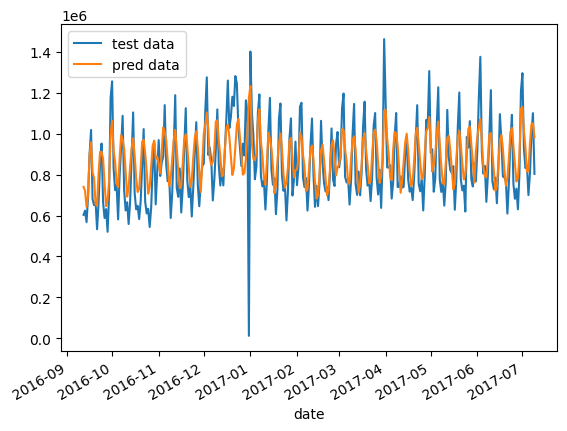

In [177]:
y_test[:steps]['sales_target_lag_1'].plot(label = 'test data')
y_pred['sales_target_lag_1'].plot(label = 'pred data')
plt.legend()
plt.show()

## Direct strategy

In [57]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

stats = feature_engineering(df)
y = stats[['sales_target_lag_1', 'sales_target_lag_2', 'sales_target_lag_3']]
X = stats.drop(['sales', 'sales_target_lag_1', 'sales_target_lag_2', 'sales_target_lag_3'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [58]:
train_mse = np.sqrt(mean_squared_error(y_train, y_fit))
test_mse = np.sqrt(mean_squared_error(y_test, y_pred))
print((f"Train RMSE: {train_mse:.2f}\n" f"Test RMSE: {test_mse:.2f}"))

Train RMSE: 2690.27
Test RMSE: 139269.02


In [180]:
from collections import deque

# rolling prediction
# in this approach if we use multiple steps forcasting at once, we are not going to have good result
stats = feature_engineering(df, target_lags = 1)

y = stats[['sales_target_lag_1']]
X = stats.drop(['sales', 'sales_target_lag_1'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = XGBRegressor()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)


test = X_test.copy()

pred = []
lag_cols = [col for col in stats.columns if 'sales_lag_' in col]


# extract last 7 sales before test for rollling mean and std
last_w_sales = stats.loc[:test.index[0], 'sales'].iloc[-8:].tolist()
history = deque(last_w_sales, maxlen = 8)


steps = min(300, len(test) - 1)
for i in tqdm(range(steps)):
    y_hat = model.predict(test.iloc[[i]])[0]
    pred.append(y_hat)
    history.append(y_hat)

    for j in range(len(lag_cols)):
        if j == 0:
            test.loc[test.index[i + 1], lag_cols[j]] = y_hat
        else:
            test.loc[test.index[i + 1], lag_cols[j]] = test.loc[test.index[i], lag_cols[j-1]]

    test.loc[test.index[i + 1], 'mean_sales_rolling'] = np.mean(list(history)[:-1])
    test.loc[test.index[i + 1], 'std_sales_rolling'] = np.std(list(history)[:-1])

  0%|          | 0/300 [00:00<?, ?it/s]

In [181]:
train_mse = np.sqrt(mean_squared_error(y_train, y_fit))
test_mse = np.sqrt(mean_squared_error(y_test[:steps], y_pred))
print((f"Train RMSE: {train_mse:.2f}\n" f"Test RMSE: {test_mse:.2f}"))

Train RMSE: 2974.44
Test RMSE: 141931.86


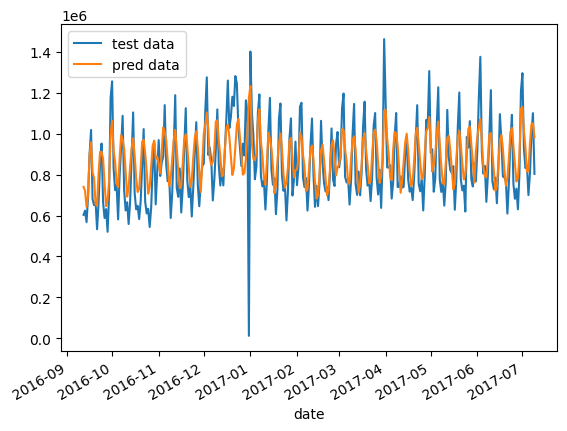

In [182]:
y_test[:steps]['sales_target_lag_1'].plot(label = 'test data')
y_pred['sales_target_lag_1'].plot(label = 'pred data')
plt.legend()
plt.show()

## SHAP (SHapley Additive exPlanations)

[documentation](https://shap.readthedocs.io/en/latest/)

[Kaggle](https://www.kaggle.com/learn/machine-learning-explainability)

[Video](https://www.youtube.com/watch?v=9haIOplEIGM)

SHAP Values break down a prediction to show the impact of each feature. It uses different subset of features and make other ones random (don't have impact on prediction), in order to realized the effect of each features.

To understand a feature’s importance in a model, it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.



- `shap.KernelExplainer(model)`:  works with all models, though it is slower than other Explainers and it offers an approximation rather than exact Shap values.
- `shap.TreeExplainer(model)`
- `shap.DeepExplainer(model)`



In [185]:
import shap

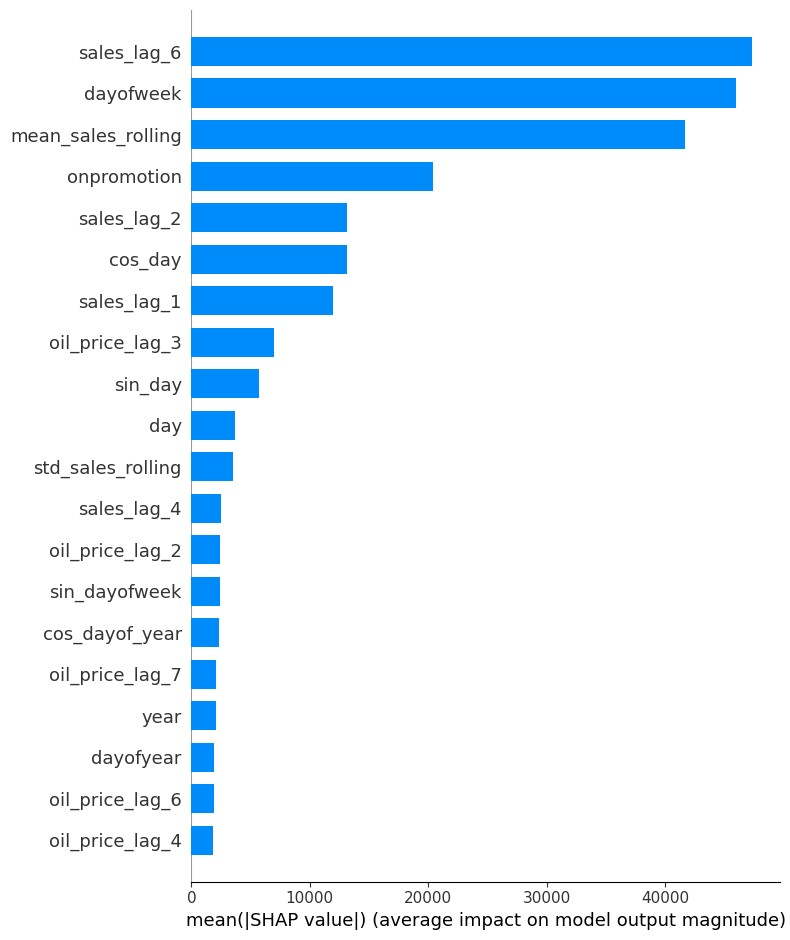

In [192]:
# explainer = shap.KernelExplainer(
#     model = model.predict,
#     data = X[:50],
#     # # link = 'identity'
# )

explainer = shap.TreeExplainer(model = model)

shap_values = explainer.shap_values(X_test[1:2])

# shap.summary_plot(shap_values, X_test[1:2])
# or for bar chart
shap.summary_plot(shap_values, X_test[1:2], plot_type="bar")

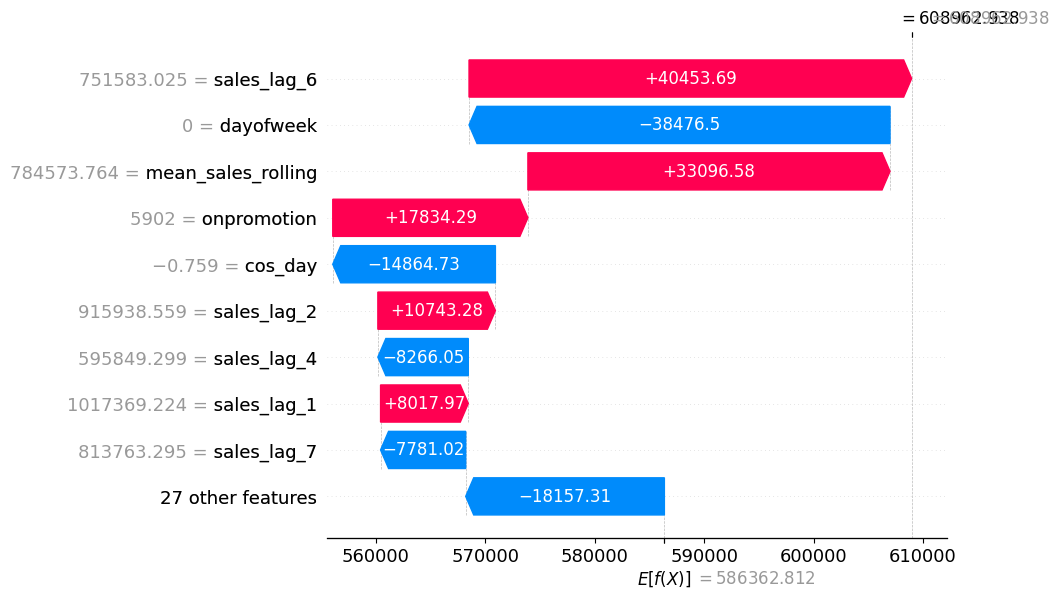

In [189]:
shap.plots.waterfall(explainer(X_test.iloc[0:1])[0])

In [700]:
# shap.dependence_plot("mean_sales_rolling", shap_values, X_test[1:2])

In [65]:
# For single prediction
shap.plots.force(
    explainer.expected_value[0],
    shap_values[0],
    X_test.iloc[0],
    # matplotlib=True
)

# # For multiple predictions
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[:100],
#     X_test.iloc[:100],
#     matplotlib=True
# )

In [704]:
# I believe this approach works for classification
# shap.initjs()
# predict = model.predict(X_test[1:2])[0]
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_test[1:2])

## Hybrid Model

In [229]:
stats = feature_engineering(df, target_lags = 1)

y = stats[['sales_target_lag_1']]
X = stats.drop(['sales', 'sales_target_lag_1'], axis=1)

# For DeterministicProcess
X.index = X.index.to_period('D')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [230]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier


fourier = CalendarFourier(freq = "YE", order=10)

# don't use the test part to avoid cheating
dp = DeterministicProcess(
    index = X_train.index,
    constant = True,
    order = 2,
    seasonal = True,
    additional_terms = [fourier],
    drop = True
)

X_train_dp = dp.in_sample()
X_test_dp = dp.out_of_sample(steps = len(X_test))

In [231]:
lr = LinearRegression(fit_intercept = False)
lr.fit(X_train_dp, y_train)

LinearRegression(fit_intercept=False)

In [232]:
y_train_trend = lr.predict(X_train_dp).reshape(-1)
y_test_trend = lr.predict(X_test_dp).reshape(-1)

y_train_trend = pd.Series(y_train_trend, index = y_train.index, name = y_train.columns[0])
y_test_trend = pd.Series(y_test_trend, index = y_test.index, name = y_train.columns[0])

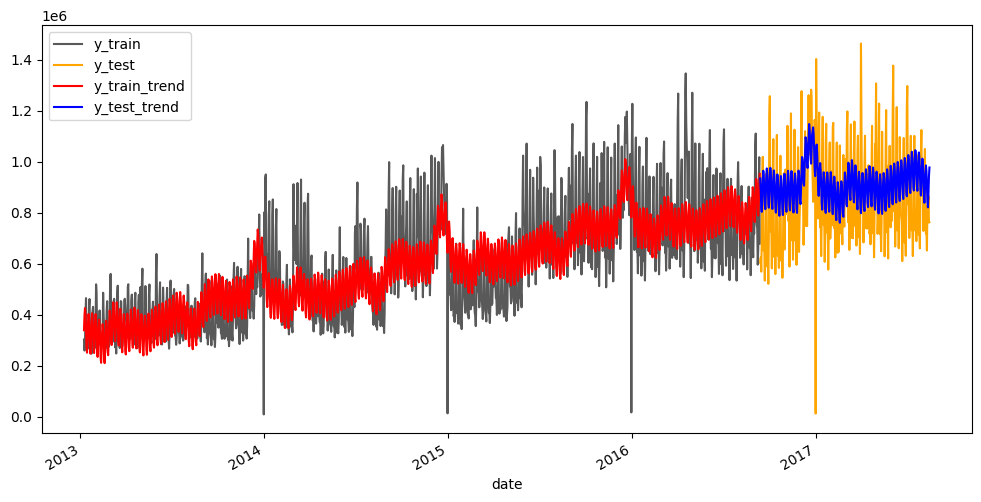

In [233]:
combined = pd.DataFrame({
    'train': y_train['sales_target_lag_1'],
    'test': y_test['sales_target_lag_1']
})

# combined.plot(figsize=(12, 6), alpha=0.7, title='Training vs Test Data')
plt.figure(figsize=(12, 6))
y_train['sales_target_lag_1'].plot(color = '0.35', label = 'y_train')
y_test['sales_target_lag_1'].plot(color = 'orange', label = 'y_test')
y_train_trend.plot(color = 'red', label = 'y_train_trend')
y_test_trend .plot(color = 'blue', label = 'y_test_trend')
plt.legend()
plt.show()

In [248]:
xgb = XGBRegressor()

residuals_train = y_train.squeeze().values - y_train_trend.values
xgb.fit(X_train, residuals_train)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_train_trend
y_fit = pd.DataFrame(y_fit_boosted, index=y_train.index, columns=y.columns)


In [257]:
from collections import deque

test = X_test.copy()
pred = []

# extract last 7 sales before test for rollling mean and std
last_w_sales = stats.loc[:y_test.index[0], 'sales'].iloc[-8:].tolist()
history = deque(last_w_sales, maxlen = 8)
lag_cols = [col for col in stats.columns if 'sales_lag_' in col]


steps = min(30, len(test) - 1)
X_test_dp = dp.out_of_sample(steps = steps)
for i in tqdm(range(steps)):
    trend = lr.predict(X_test_dp.iloc[[i]])[0][0]
    y_hat = xgb.predict(test.iloc[[i]])[0] + trend

    pred.append(y_hat)
    history.append(y_hat)

    # Replace new prediction to avoid cheating
    for j in range(len(lag_cols)):
        if j == 0:
            test.loc[test.index[i + 1], lag_cols[j]] = y_hat
        else:
            test.loc[test.index[i + 1], lag_cols[j]] = test.loc[test.index[i], lag_cols[j-1]]

    test.loc[test.index[i + 1], 'mean_sales_rolling'] = np.mean(list(history)[:-1])
    test.loc[test.index[i + 1], 'std_sales_rolling'] = np.std(list(history)[:-1])

y_pred = pd.DataFrame(pred, index=y_test[:steps].index, columns=y.columns)

  0%|          | 0/30 [00:00<?, ?it/s]

In [258]:
train_mse = np.sqrt(mean_squared_error(y_train, y_fit))
test_mse = np.sqrt(mean_squared_error(y_test[:steps], y_pred))
print((f"Train RMSE: {train_mse:.2f}\n" f"Test RMSE: {test_mse:.2f}"))

Train RMSE: 3406.20
Test RMSE: 109271.71


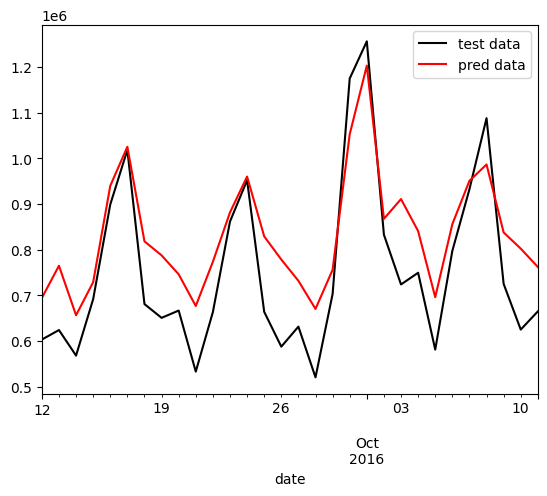

In [259]:
y_test[:steps]['sales_target_lag_1'].plot(label = 'test data', color = 'black')
y_pred['sales_target_lag_1'].plot(label = 'pred data', color = 'r')
plt.legend()
plt.show()

In [ ]:
!pip install optuna

In [264]:
# import optuna

# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 8),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0)
#     }
#     model = XGBRegressor(**params, random_state=42)
#     model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
#     preds = model.predict(X_test)
#     return np.mean(np.abs(preds - y_test))  # MAE

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)
# best_params = study.best_params